In [22]:
#import Git4
import math
%run Git4.py

# WRE Project

### Calibration

1. Report the best fit parameters for the hydrological model.

In [165]:
# Pest Parameters
# Valeur empirique trouvée par itération de l'algo
best_param = [9e-7, 4.74, 84.04, 14]
K_sat=9e-7
c=4.74               # [-] exponent of ksat for the equation k = ksat * s^c
t_sub=84.04           # [h] mean sub-superficial residence time
z=14

A=4000*1e6

4. Plot Markov chains of the calibrated parameters and sequences of values of N S and
TSA as a function of the number of iterations. Only plot accepted parameter sets.

### Hydrological variables

In [166]:
[Q, R, I, s, L, ET]=Git4.hydr_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

2. Plot the time series (6-year-long) of precipitation in [mm/h], run off in [mm/h],
infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in
[mm/h] for the calibrated hydrological model forced by the given precipitation).

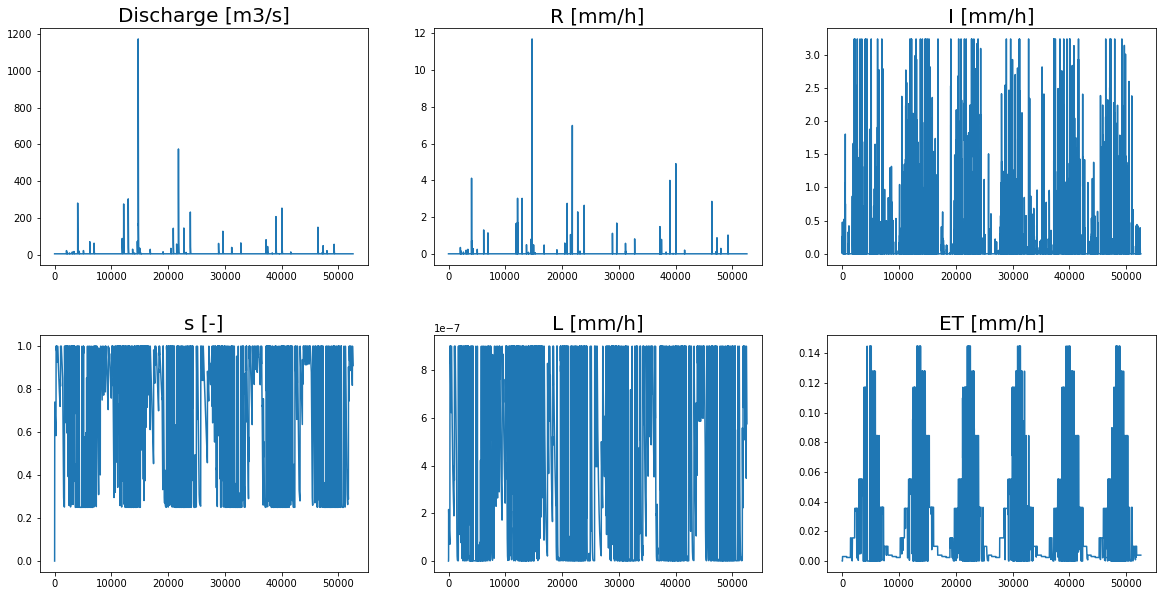

In [167]:
plot_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

### Discharge


3. Plot the time series of observed discharge and of the discharge as simulated by the
hydrological model with the best fit parameters.

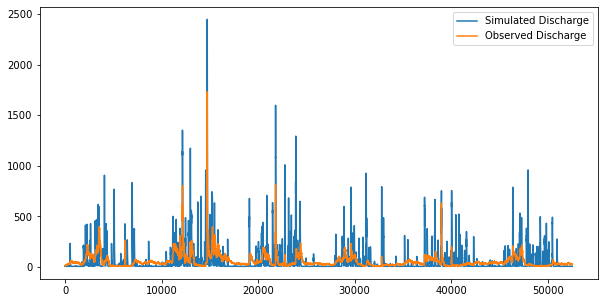

In [27]:
figure=plt.figure(figsize=(10,5))
plt.plot(Q, label="Simulated Discharge")
plt.plot(Q_obs,label="Observed Discharge")

plt.legend()

Attention, si ne marche pas, problème A, plusieurs variables A

### Generation of precipitation

5. Plot the comparison between the statistics (mean, standard deviation, α and λ) of
the observed and generated precipitation

In [174]:
day_month=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] #"day_month": number of days for each month
month_end=np.cumsum(day_month)-1                    #"month_end": last day of each month
month_start=month_end-day_month+1

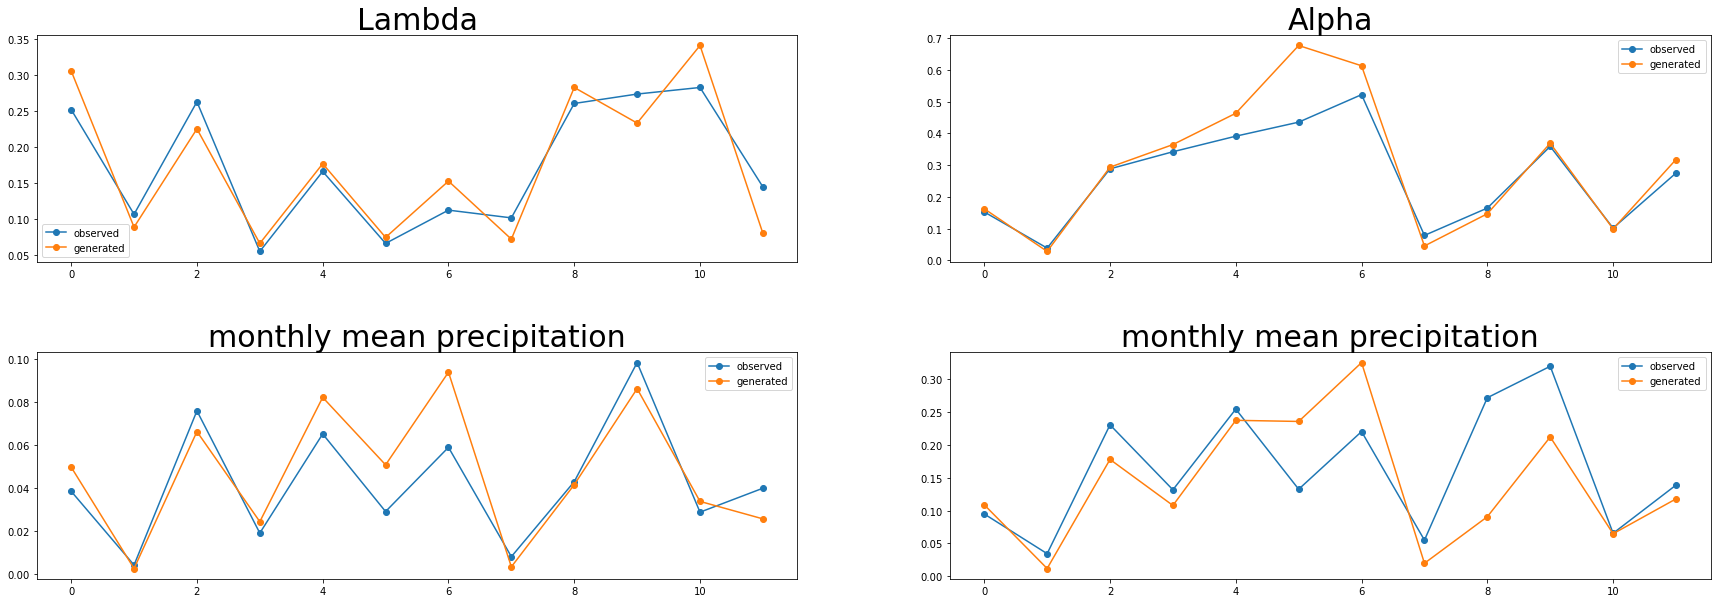

In [404]:
P=rain_gen(years=100,plot=True)

### DEMANDER SI OK
+ comment

### Simulation of hydrological variables

6. Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in
[mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotran-
spiration in [mm/h] for the calibrated hydrological model forced by the generated
precipitation)

In [399]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)


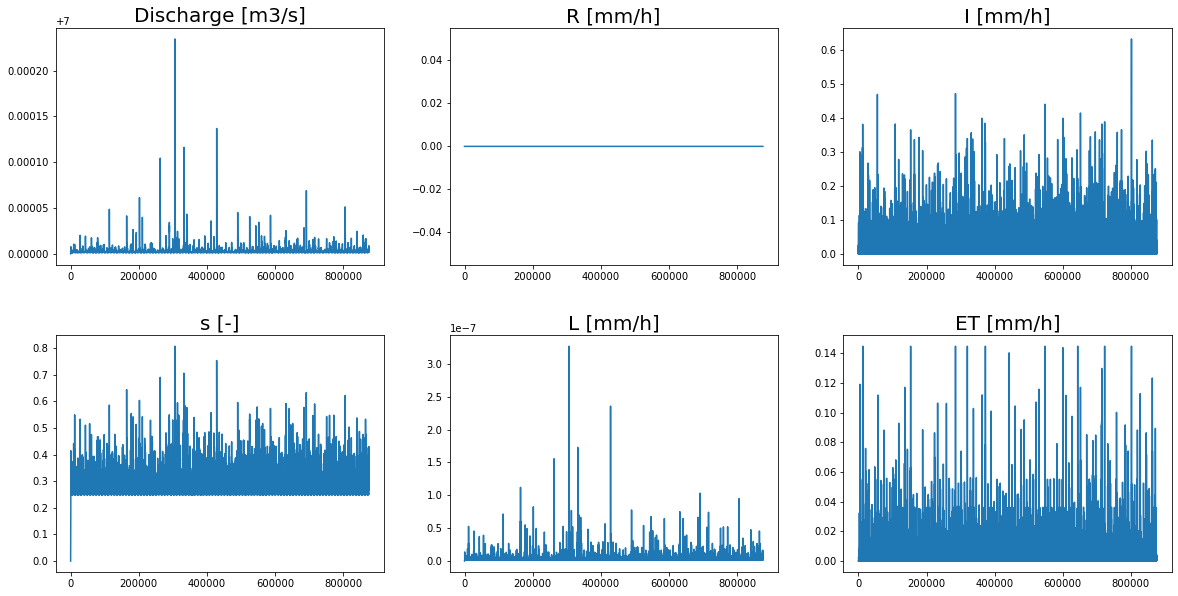

In [401]:
plot_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

### Reservoir Area and Volume Rating curves

7. Plot the area and the volume rating curves for the given levels.

Text(0.5, 1.0, 'Area Rating curve')

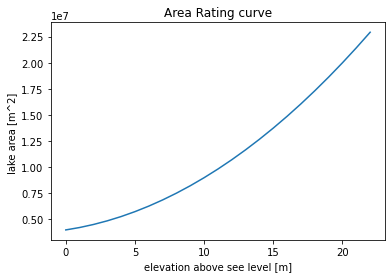

In [32]:
elevation=[k for k in range (0,23)]
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,A_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake area [m^2] ")
plt.title("Area Rating curve")

Text(0.5, 1.0, 'Volume Rating curve')

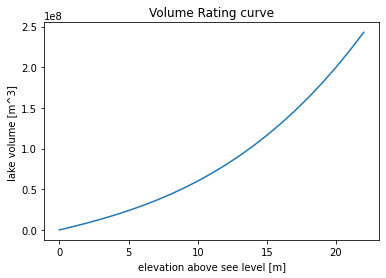

In [34]:
V_rating=vol_rat_curve(A_rating)
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,V_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake volume [m^3] ")
plt.title("Volume Rating curve")

### Discharge and reservoir routine

8. Report the minimum flow (discharge that is equalled or exceeded 95% of the time)
of the generated discharge and plot the discharge duration curves

Q347= 7.000000101568959 m3/s


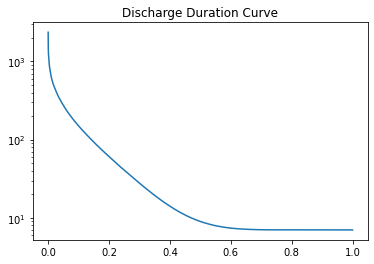

In [35]:
print("Q347= " +str(Q_347(Q, plot=True))+" m3/s") # m3/s

9. For a maximum level for hydroelectric use of 15 m, plot the time series (100 years
long) of input discharge, output discharge, volume within the reservoir and level

In [73]:
#parameters of the reservoir
Cqg = 0.6 # [-] sluice gate discharge coefficient
Cqs = 0.7 # [-] spillway discharge coefficient
Lspill = 140 # [m] spillway effective length
p = 19 # [m]  difference between spillway level and minimum level

#parameters of power plant
QT = 30 # [m/s] design discharge of the hydro PP
D = 3.6 # [m]
Lp = 1200 # [m]
ks = 0.5 # [mm]
eta = 0.75 # [-] Careful, more than one eta
Deltaz = 75 # [m] difference in height between the elevation of the empty lake 
                # (headwater) and the tailwater 
lmin_HU = 9 # [m] min height for electricity generation

Qlim = 100 #[m3/s]
g = 9.806 # [m/s2] gravity

f = (1/(-2*np.log(ks/(1000*D*3.7))))**2#Colebrook equation
A_pipe=np.pi*D**2
kL = f*Lp/(2*g*D*A_pipe**2) + 1.5/(2*g*A_pipe**2)      #Loss coefficient


#Power=9806*net_head*Q*eta/1000000    %[MW]
gamma=g*1000
Energy_price=75

In [94]:
gamma*eta

7354.5

In [150]:
def reservoir_routine(Q,P,ET,volume_rating_curve,lmax_HU=15):
    """
    Inputs :
        - Q [m3/s] the flow entering the dam
        - P [mm/h] the precipitation over the whole basin
        - ET [mm/h] the evapotranspiration
        - volume_rating_curve [m] - [m3] the discrete function between the level
            of the lake and its volume
        - lmax_HU [m] maximum level for hydropower production
        
    Output :
        V,l,A_sluice,Q_out,Q_HU,Q_g)
        - V [m3] a list of length n describing the total volume in the dam
        - l [m] a list of length n describing the level in the dam
        - A_sluice [m2] a list of length n describing the open area of the sluice
            to let the ater out in the river
        - Q_out [m3/s] a list of length n describing the flow that exits the
            dam to the river (NOT power generation !)
        - Q_HU [m3/s] a list of length n describing the flow used for power
            generation (does NOT to river)
        - Q_g [m3/s] a list of length n describing the flow that goes through 
            the sluice gate only (NOT the spillway)
        - Pow [Watt] turbine power generation
        - profit [CHF]
        - p_flood
        - E_annual [GWh]
        
    TO-DO :
        - integrate the power generation calculation ? (not sure)
    """
    
    # Variable to calculate
    dt = 3600 # [s] time step integration
        # [m3/s]
    n = len(Q)
    Q_ind = Q_S(P,ET) # [m3/s]
    Q347 = Q_347(Q,plot=False)
    
    print(Q347)
    # variable initialization
    V = [0]*n         # [m3]
    l = [0]*n         # [m] level of the reservoir depending on time
    A_sluice = [0]*n  # [m2] area of the opening of the sluice gate (see Q_g)
    Q_out = [0]*n     # [m3/s] total water out of the dam
    Q_HU = [0]*n      # [m3/s] water going through turbine to generate power
    Q_g = [0]*n       # [m3/s] water flow through the gate
    Pow=[0]*n         # [Watt] Power generated by the turbine
    Y=[0]*n
    #Initialization
    l[0] = 14 
    V[0] = lvl_to_vol(l[0], volume_rating_curve)
    Vmax_HU = lvl_to_vol(lmax_HU, volume_rating_curve)
    
    # for 24 hours when is the turbine working (peak hours)
    turbine_hours = [int(x >= 8 and x < 21) for x in range(24)]
    turbine_state = int(l[0] > lmin_HU)     # 1 if the turbine is on for the 
                                            # whole day, 0 otherwise 
    # flood condition an damages
    y_lim = 0.1*np.sqrt(Qlim)+0.5 # maximum y before flood
    damage=0 # CHF, Damages 
    flood=False # Are we in a flood event or not?
    maxy=0 # maximum of height in a flood event
    n_flood=0
    
    for t in range(n-1):
        
        
        h = t%24
        # is the turbine working during this day ? update if it is midnight
        if h == 0:
            turbine_state = int(l[t] > lmin_HU)
        
        Q_HU[t] = turbine_state * turbine_hours[h] * QT    # [m3/s]
            
        Q_g[t] = max(Q347 , min(Qlim,(V[t]+(Q[t]-Q_HU[t]-Q_ind[t])*dt-Vmax_HU)/dt) )  # [m3/s]
        #print(Cqg*np.sqrt(2*g*l[t]))
        if l[t]==0:
            A_sluice[t]=0
        else:
            A_sluice[t] = Q_g[t] / (Cqg*np.sqrt(2*g*l[t]))  # [m2] 
        
        # does the water spills over the dam ?
        if l[t]<=p:
            Q_out[t] = Q_g[t] #  [m3/s]
        else:
            Q_out[t] = Q_g[t] + Cqs*Lspill*np.sqrt(2*g*(l[t]-p)**3)  #[m3/s]
            
        # update volume and level
        V[t+1]=V[t]+(Q[t]-Q_out[t]-Q_HU[t]-Q_ind[t])*dt
        l[t+1] = vol_to_lvl(V[t+1], volume_rating_curve)
        
        # power generation of the turbine [W]
        HT = l[t] + Deltaz - kL*QT**2   # QHU ou QT, same 
        Pow[t]=eta*gamma*Q_HU[t]*HT     # [Watt]
        
        
        # Detection of flood event
        if Q_out[t] > (Qlim + 1):
            n_flood=n_flood+1
            
        y=0.1*np.sqrt(Q_out[t])
        Y[t]=y
        #print("y= " +str(y))
            
        if flood: # We are in a flood event
            if y<y_lim:
                # End of the flood event
                #print("end of the flood")
                z=maxy-y_lim
                maxy=0
                flood=False
                #print(z)
                damage=damage+(1+z)**2.25
                #print(z)
                #print(damage*1000000)
            else:
                # Still in the flood event
                if y>maxy:
                    maxy=y
                     
        elif y>=y_lim:
            flood=True
            #print("flood y = " + str(y))# Beginning of a flood event
            maxy=y

    
    p_flood=n_flood/n
    #RAPPEL UNITES : 1 MWh = 3600 MJ / np.sum(Pow)*3600 [J]  / np.sum(Pow) *10e-6 [MWh]
    # 
    Total_energy=np.sum(Pow)*10**(-6) # MWh
    E_annual=Total_energy*365*24/n # [MWh]
    profit= Total_energy*Energy_price - damage*1000000
    
    return (V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Y)

In [151]:
P=rain_gen(years=6,plot=False)
#Energy_price=75
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Y]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=15)

7.000000409623896


In [155]:
for i in range (0,len(Q_g)):
    if Q_g[i]==0:
        print(i)

52559


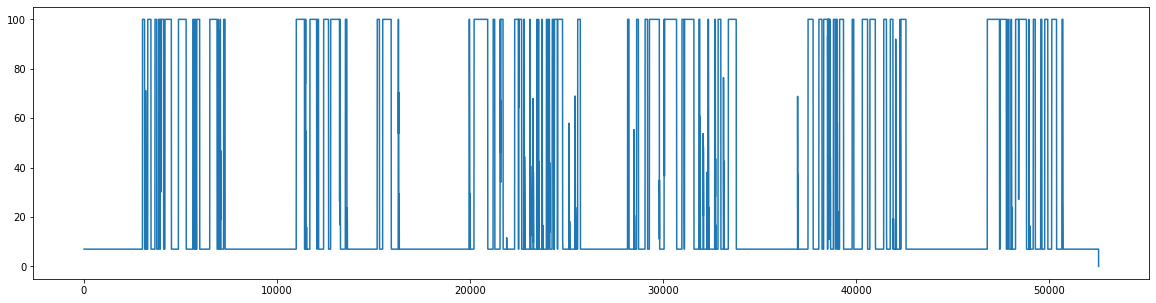

In [160]:
plt.figure(figsize=(20,5))
plt.plot(Q_g)

In [153]:
max(Q347 , min(Qlim,0) ) 

7.000000030962152

In [147]:
Q347

7.000000030962152

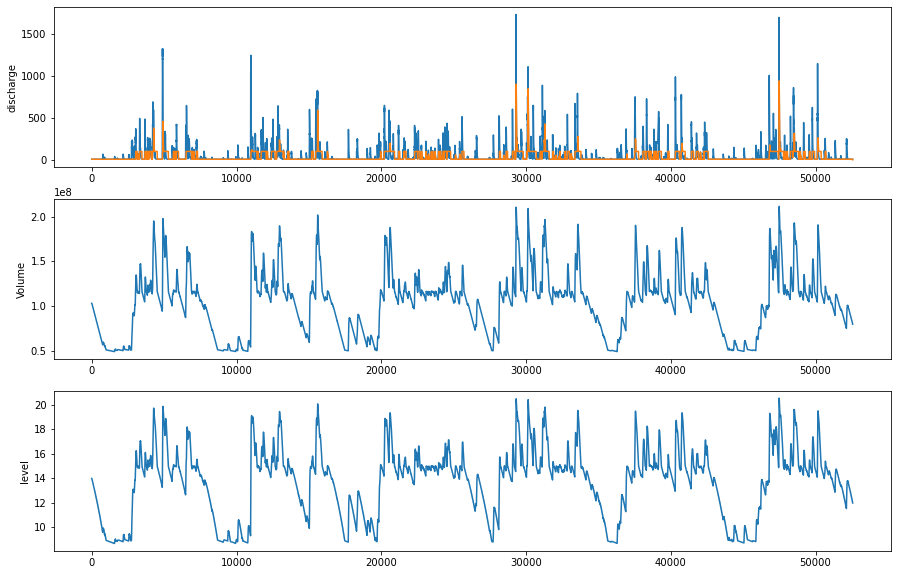

In [161]:
plot_routine(Q,Q_out,V,l)

10. Plot the average annual energy production in [GWh] and the probability that Qout
exceeds Qlim for different values of the maximum level for hydroelectrical use.

In [122]:
lmax=np.linspace(9,19,21)
energy=[]
money=[]
prob_flood=[]
for element in lmax:
    [V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=element)
    energy.append(E_annual)
    money.append(profit)
    prob_flood.append(p_flood)

flood y = 1.5403705893834605
end of the flood
flood y = 1.548875984353759
end of the flood
flood y = 1.682220074697763
end of the flood
flood y = 1.5545046823422297
end of the flood
flood y = 1.5124568004006134
end of the flood
flood y = 1.56933612323285
end of the flood


ValueError: too many values to unpack (expected 10)

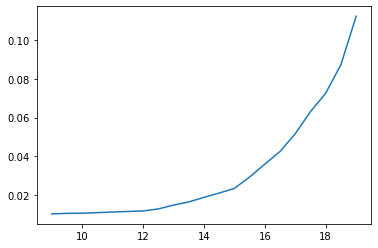

In [97]:
#plt.plot(lmax,money)
plt.plot(lmax,prob_flood)

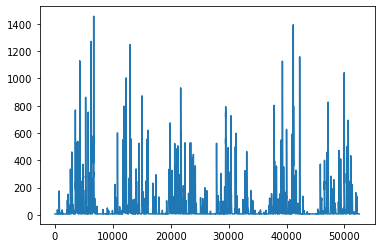

In [128]:
plt.plot(Q)

# Climate change